In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import os, sys, re, gc, glob
from tqdm.auto import tqdm, trange
from utils import JDIDataset, JDIModel, get_grey_image, assign_labels, accuracy

import seaborn as sns

2021-05-28 23:56:38,707 -INFO - config:config.py:16 - Module utils.config was loaded
2021-05-28 23:56:38,711 -INFO - common:common.py:569 - Module utils.common is loaded...
2021-05-28 23:56:38,711 -INFO - hidden:hidden.py:62 - hidden module is loaded
2021-05-28 23:56:38,715 -INFO - dataset_builder:dataset_builder.py:200 - dataset package is loaded...
2021-05-28 23:56:38,721 -INFO - dataset:dataset.py:650 - dataset module is loaded...


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
DEVICE='cpu'

In [4]:
model = torch.load('model/model.pth').to(DEVICE)
model.eval()

JDIModel(
  (input_layer): Linear(in_features=5629, out_features=128, bias=False)
  (batchNorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden1): Linear(in_features=128, out_features=32, bias=False)
  (batchNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden2): Linear(in_features=32, out_features=22, bias=True)
)

## Load test dataset

In [5]:
dataset_name = 'html-5'


In [6]:
dataset = JDIDataset(dataset_names=[dataset_name], rebalance=False)

2021-05-28 23:56:40,130 -INFO - dataset:dataset.py:247 - List of dataset_names:['html-5']
2021-05-28 23:56:40,131 -INFO - dataset:dataset.py:253 - Dataset for html-5
2021-05-28 23:56:40,198 -INFO - dataset:dataset.py:255 - Dataset shape: (665, 13)
2021-05-28 23:56:40,199 -INFO - dataset:dataset.py:257 - cleaning tag_name from dummy/auxiliary words
2021-05-28 23:56:40,316 -INFO - hidden:hidden.py:48 - build field "is_hidden"
2021-05-28 23:56:40,528 -INFO - dataset:dataset.py:48 - select all leafs (nodes which are not parents)
2021-05-28 23:56:40,528 -INFO - dataset:dataset.py:51 - Leafs set size: 413 (nodes which have no children)
2021-05-28 23:56:40,532 -INFO - dataset:dataset.py:54 - count number of references to leafs
2021-05-28 23:56:40,534 -INFO - dataset:dataset.py:58 - Nodes with leafs as children set size: 165 (nodes which have leafs as children)
2021-05-28 23:56:40,536 -INFO - dataset:dataset.py:61 - count num children for each node
2021-05-28 23:56:40,536 -INFO - dataset:datas

  0%|          | 0/665 [00:00<?, ?it/s]

2021-05-28 23:56:41,784 -INFO - dataset:dataset.py:275 - Dataset shape after merging with parents: (665, 46)
2021-05-28 23:56:41,784 -WARNING - dataset:dataset.py:281 - Load LABELS from dataset/annotations/html-5.txt


Assigning labels:   0%|          | 0/132 [00:00<?, ?it/s]

2021-05-28 23:56:42,133 -INFO - dataset:dataset.py:297 - Concatenate datasets
2021-05-28 23:56:42,138 -INFO - dataset:dataset.py:299 - Dataset shape after reading: (665, 49)
2021-05-28 23:56:42,140 -WARNING - dataset:dataset.py:630 - Loading count vectorizer for column "cv_class": model/count_vectorizer_class.pkl
2021-05-28 23:56:42,143 -INFO - dataset:dataset.py:647 - class_sm: (665, 1081)
2021-05-28 23:56:42,144 -INFO - dataset:dataset.py:308 - Build OHE column for attribute role
2021-05-28 23:56:42,146 -INFO - dataset:dataset.py:308 - Build OHE column for attribute type
2021-05-28 23:56:42,148 -INFO - dataset:dataset.py:308 - Build OHE column for attribute ui
2021-05-28 23:56:42,151 -INFO - dataset:dataset.py:313 - Build OHE column for attribute role_parent
2021-05-28 23:56:42,152 -INFO - dataset:dataset.py:313 - Build OHE column for attribute type_parent
2021-05-28 23:56:42,155 -INFO - dataset:dataset.py:313 - Build OHE column for attribute ui_parent
2021-05-28 23:56:42,157 -INFO -

In [7]:
dataset.dataset.shape

(665, 58)

In [8]:
dataset.labels

0       n/a
1       n/a
2       n/a
3       n/a
4       n/a
       ... 
660     n/a
661     n/a
662     n/a
663    link
664    link
Name: label, Length: 665, dtype: object

In [9]:
dataset.dataset.label

0      21
1      21
2      21
3      21
4      21
       ..
660    21
661    21
662    21
663     1
664     1
Name: label, Length: 665, dtype: int32

In [10]:
dataloader=DataLoader(dataset, shuffle=False, batch_size=1, collate_fn=dataset.collate_fn, pin_memory=True)

In [11]:
results = []
softmax = torch.nn.Softmax(dim=1)
with trange(len(dataloader)) as bar:
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = softmax(model(x.to(DEVICE))) # get prediction logits, and convert them to probabilities
            # print(y_pred.__repr__())
                                                   
            y_prob = y_pred.to('cpu').detach().numpy()
            y_pred = y_prob[0].argmax()
            
            y_prob = y_prob[0, y_pred].item()
            y = y.item()           
            
            results.append({
                'y_true': y,
                'y_pred': y_pred,
                'y_probability': y_prob,
                'y_true_label': dataset.classes_reverse_dict[y], 
                'y_pred_label': dataset.classes_reverse_dict[y_pred]
            })
            bar.update(1)

results_df = pd.DataFrame(results)
results_df['is_hidden'] = dataset.dataset.is_hidden.values

  0%|          | 0/665 [00:00<?, ?it/s]

In [12]:
list(dataset.classes_dict.keys())

['button',
 'link',
 'iframe',
 'textfield',
 'dropdown',
 'checkbox_btn',
 'checkbox_label',
 'radiobutton_btn',
 'radiobutton_label',
 'textarea',
 'text',
 'fileinput',
 'image',
 'colorpicker',
 'range',
 'progressbar',
 'datetimeselector',
 'numberselector',
 'dropdownselector',
 'checklist',
 'table',
 'n/a']

In [13]:
r_df = results_df[~((results_df.y_true_label == 'n/a') & (results_df.y_pred_label == 'n/a'))]

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=r_df.y_true_label.values,
                     y_pred=r_df.y_pred_label.values, 
                     labels=list(dataset.classes_dict.keys())
                    ), 
    columns=list(dataset.classes_dict.keys()),
    index=list(dataset.classes_dict.keys())
)



In [14]:
confusion_matrix_df

,button,link,iframe,textfield,dropdown,checkbox_btn,checkbox_label,radiobutton_btn,radiobutton_label,textarea,...,image,colorpicker,range,progressbar,datetimeselector,numberselector,dropdownselector,checklist,table,n/a
button,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
link,0,72,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iframe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textfield,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dropdown,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checkbox_btn,0,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checkbox_label,0,0,0,0,0,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
radiobutton_btn,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
radiobutton_label,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
textarea,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [15]:
import seaborn as sns


<AxesSubplot:>

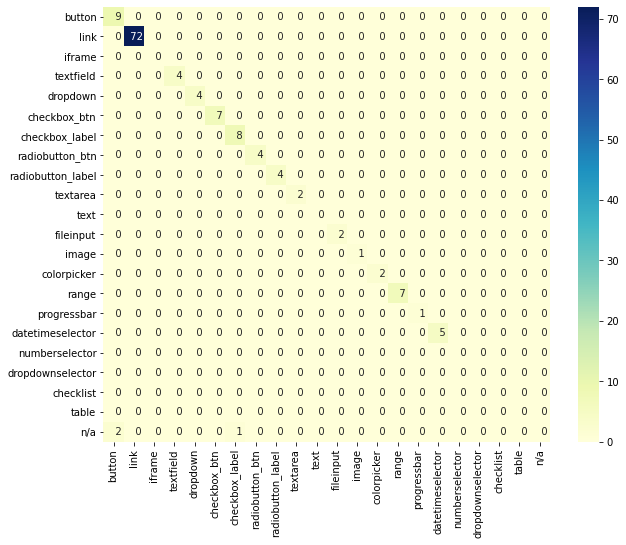

In [16]:
plt.figure(figsize=(10,8))
display(sns.heatmap(confusion_matrix_df, annot=True, fmt="4d", cmap="YlGnBu"));
plt.show()
#display(sns.heatmap(confusion_matrix_df[:-1][confusion_matrix_df.columns[:-1]], annot=True, fmt="4d", cmap="YlGnBu"));
#plt.show();


In [17]:
dataset_name

'html-5'

In [18]:
accuracy(results_df)

2021-05-28 23:56:44,483 -INFO - common:common.py:438 - Accuracy:  21/21 = 1.0, for 665 elements


1.0

In [19]:
dataset.classes_dict

{'button': 0,
 'link': 1,
 'iframe': 2,
 'textfield': 3,
 'dropdown': 4,
 'checkbox_btn': 5,
 'checkbox_label': 6,
 'radiobutton_btn': 7,
 'radiobutton_label': 8,
 'textarea': 9,
 'text': 10,
 'fileinput': 11,
 'image': 12,
 'colorpicker': 13,
 'range': 14,
 'progressbar': 15,
 'datetimeselector': 16,
 'numberselector': 17,
 'dropdownselector': 18,
 'checklist': 19,
 'table': 20,
 'n/a': 21}

In [20]:

dataset.dataset['label_text_predicted'] = results_df.y_pred_label
dataset.dataset['probability'] = results_df.y_probability


(6242, 1200)


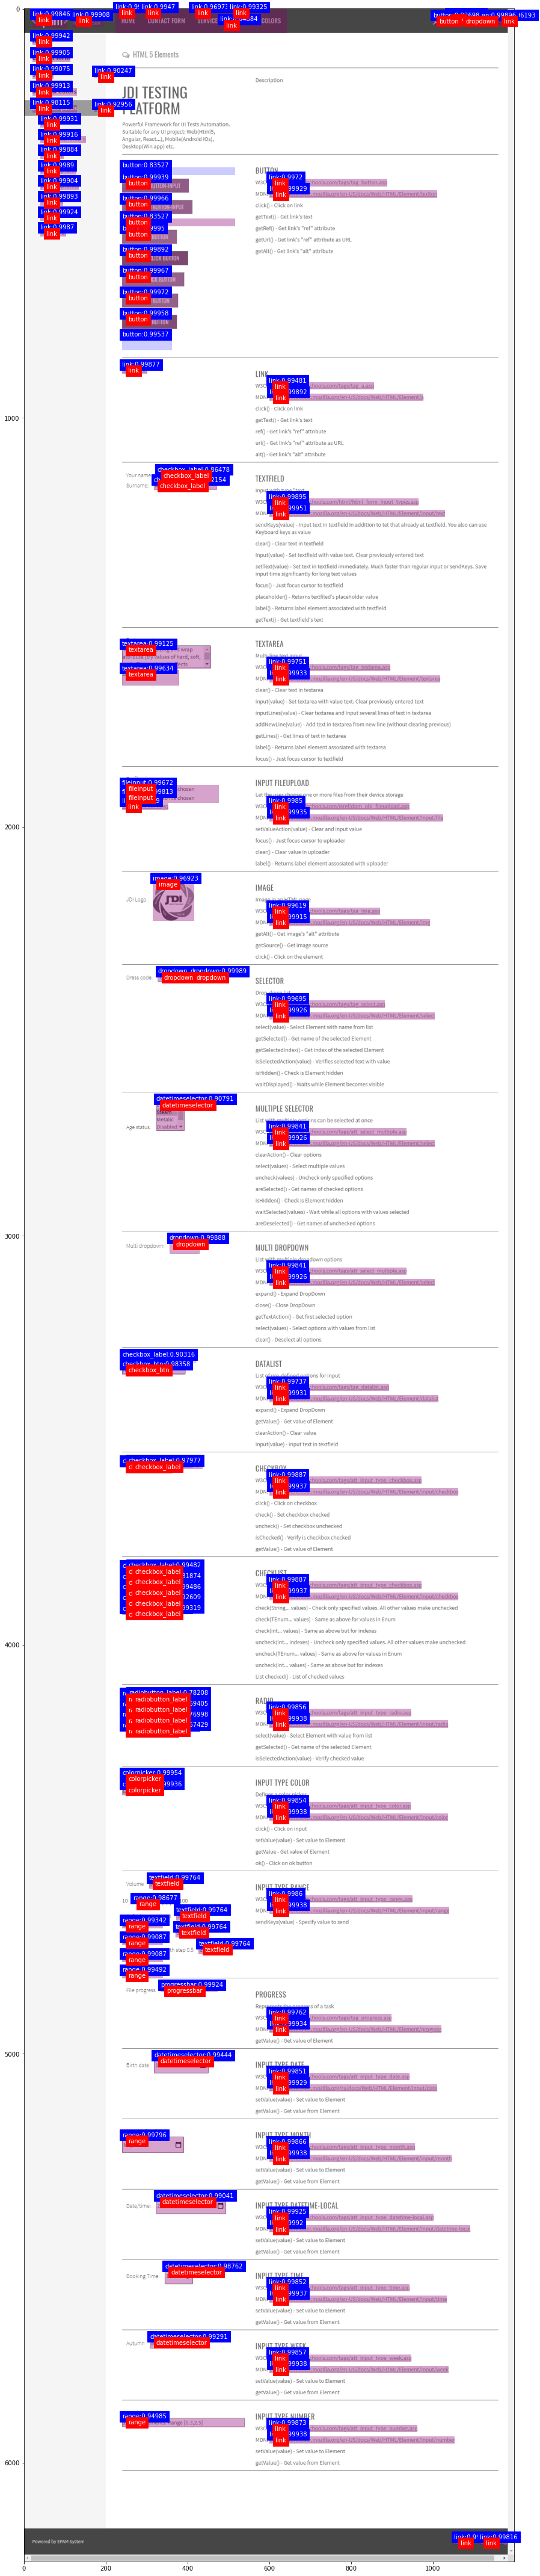

In [21]:
gray_img = get_grey_image(f'dataset/images/{dataset_name}.png')
print(gray_img.shape)

IMG_SIZE = 15
_h = gray_img.shape[0]/gray_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(gray_img, cmap='gray')
axes = plt.gca()

for i, r in dataset.dataset[dataset.dataset.label_text_predicted != 'n/a'].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    
    if (r.x<0) or (r.y<0): # or (r.x>r.width): #or (r.y>r.height):
        continue
        
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'blue')
    axes.add_patch(patch)
    axes.text(r.x, r.y, r.label_text_predicted+':'+str(round(r.probability, 5)), color='white', backgroundcolor='blue')

for i, r in dataset.dataset[dataset.dataset.label != dataset.dummy_class_value].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+15, r.y+15, dataset.classes_reverse_dict[r.label], color='white', backgroundcolor='red')
    




In [22]:
results_df

,y_true,y_pred,y_probability,y_true_label,y_pred_label,is_hidden
0,21,21,0.998789,n/a,n/a,0
1,21,21,0.999955,n/a,n/a,0
2,21,21,0.999533,n/a,n/a,0
3,21,21,1.000000,n/a,n/a,1
4,21,21,1.000000,n/a,n/a,1
...,...,...,...,...,...,...
660,21,21,0.999769,n/a,n/a,0
661,21,21,0.995577,n/a,n/a,0
662,21,21,0.999863,n/a,n/a,0
663,1,1,0.998888,link,link,0


In [23]:
dataset.dataset[:1].to_json(orient='records')

'[{"attributes":{"accept":null,"alt":null,"charset":null,"checked":null,"class":null,"cols":null,"content":null,"data-placement":null,"data-toggle":null,"dir":null,"disabled":null,"download":null,"for":null,"height":null,"href":null,"http-equiv":null,"id":null,"index":null,"lang":"en","language":null,"list":null,"max":null,"maxlength":null,"min":null,"minlength":null,"multiple":null,"name":null,"onchange":null,"onclick":null,"oncontextmenu":null,"ondblclick":null,"oninput":null,"placeholder":null,"rel":null,"required":null,"role":null,"rows":null,"selected":null,"size":null,"src":null,"step":null,"style":null,"tabindex":null,"target":null,"title":null,"type":null,"ui":null,"value":null,"width":null,"wrap":null},"displayed":true,"element_id":"6194400565668651573001447234","height":6225.0,"onmouseenter":null,"onmouseover":null,"parent_id":"6194400565668651573001447234","style":["align-content","align-items","align-self","alignment-baseline","animation-delay","animation-direction","animat

In [24]:
dataset.dataset.columns

Index(['attributes', 'displayed', 'element_id', 'height', 'onmouseenter',
       'onmouseover', 'parent_id', 'style', 'tag_name', 'text', 'width', 'x',
       'y', 'is_hidden', 'is_leaf', 'num_leafs', 'num_children',
       'sum_children_widths', 'sum_children_hights', 'children_tags',
       'num_followers', 'followers_tags', 'max_depth', 'attributes_parent',
       'displayed_parent', 'element_id_parent', 'height_parent',
       'onmouseenter_parent', 'onmouseover_parent', 'parent_id_parent',
       'style_parent', 'tag_name_parent', 'text_parent', 'width_parent',
       'x_parent', 'y_parent', 'is_hidden_parent', 'is_leaf_parent',
       'num_leafs_parent', 'num_children_parent', 'sum_children_widths_parent',
       'sum_children_hights_parent', 'children_tags_parent',
       'num_followers_parent', 'followers_tags_parent', 'max_depth_parent',
       'scalar', 'label', 'ds_name', 'cv_class', 'ohe_role', 'ohe_type',
       'ohe_ui', 'ohe_role_parent', 'ohe_type_parent', 'ohe_ui_paren